In [67]:
import os
import pandas as pd
from tqdm import tqdm

Read files


In [68]:
# read files from output directory
output_dir = '../output_test_sample'
output_files = os.listdir(output_dir)
output_files 

['llava_img_True_country_True.csv',
 'llava_img_False_country_False.csv',
 'llava_img_True_country_False.csv',
 'llava_img_False_country_True.csv']

In [69]:
from datasets import load_dataset

go_dataset = load_dataset("Anthropic/llm_global_opinions")

# load as a pandas dataframe where 'source' == wvs
go_dataset_df = go_dataset['train'].to_pandas()
go_dataset_wvs = go_dataset_df[go_dataset_df['source'] == 'WVS']
go_dataset_wvs.head()

,question,selections,options,source
2203,How satisfied are you with the following?\n\nT...,"defaultdict(<class 'list'>, {'Iraq': [0.288000...","['Completely dissatisfied', 'Rather dissatisfi...",WVS
2204,"Please tell us if you strongly agree, agree, d...","defaultdict(<class 'list'>, {'Ethiopia': [0.07...","['Strongly agree', 'Agree', 'Disagree', 'Stron...",WVS
2205,"Please tell us if you strongly agree, agree, d...","defaultdict(<class 'list'>, {'Ethiopia': [0.21...","['Strongly agree', 'Agree', 'Disagree', 'Stron...",WVS
2206,"In your view, how often do the following thing...","defaultdict(<class 'list'>, {'Albania': [0.075...","['Very often', 'Fairly often', 'Not often', 'N...",WVS
2207,I am going to name a number of organizations. ...,"defaultdict(<class 'list'>, {'Hong Kong SAR': ...","['A great deal', 'Quite a lot', 'Not very much...",WVS


In [70]:
import shutil
img_comparison = True
img_country_comparison = False

if img_comparison:
    setting_1 = 'Image False, Country True'
    setting_2 = 'Image False, Country False'
    file_1 = os.path.join(output_dir, 'llava_img_False_country_True.csv')
    file_2 = os.path.join(output_dir, 'llava_img_False_country_False.csv')
    image_dir = '../jsd_percountry_images_true_country_false'
elif img_country_comparison:
    setting_1 = 'Image True, Country False'
    setting_2 = 'Image False, Country True'
    file_1 = os.path.join(output_dir, 'llava_img_True_country_False.csv')
    file_2 = os.path.join(output_dir, 'llava_img_False_country_True.csv')
    image_dir = '../jsd_percountry_images_true_country_true'

# delete all files in the directory if exists
# if os.path.exists(image_dir):
#     shutil.rmtree(image_dir)
# os.makedirs(image_dir)

df_1 = pd.read_csv(file_1) # image true
df_2 = pd.read_csv(file_2) # image false

In [71]:
import ast

def convert_to_list(x):
    x = ast.literal_eval(x) 
    x_list = list(x.values()) if isinstance(x, dict) else list(x)
    return x_list

def get_distribution_list(df, options_prob_col, wvs_distribution_col):
    options_prob_dict = [convert_to_list(val) for val in df[options_prob_col]]
    df['options_prob_list'] = pd.Series(options_prob_dict)
    
    wvs_distribution = [convert_to_list(val) for val in df[wvs_distribution_col]]
    df['wvs_distribution_list'] = wvs_distribution
    
    return df

# Assuming df_1 and df_2 are already defined DataFrames
df_1 = get_distribution_list(df_1, 'options_prob', 'wvs_distribution')
df_2 = get_distribution_list(df_2, 'options_prob', 'wvs_distribution')

In [72]:
wvs_questions = go_dataset_wvs['question'].unique()
model_questions = df_1['question'].unique()

common_questions = set(wvs_questions).intersection(set(model_questions))
len(common_questions)

# for all unique value in questions column, find "options" value from go_dataset_wvs and add to df_aggregated
def add_options_to_df(questions, df_aggregated, go_dataset_wvs):
    for question in questions:
        options = go_dataset_wvs[go_dataset_wvs['question'] == question]['options'].values[0]
        # create a new column with options
        # breakpoint()

        df_aggregated.loc[df_aggregated['question'] == question, 'options'] = options
    return df_aggregated

df_aggregated_1 = add_options_to_df(common_questions, df_1, go_dataset_wvs)
df_aggregated_2 = add_options_to_df(common_questions, df_2, go_dataset_wvs)

In [73]:
df_aggregated_1.head(2)

,useimage,usecountry,ques_idx,question,image_id,img_path,country,top10_token_prob,options_prob_percent,options_prob,wvs_distribution,prompt,options_prob_list,wvs_distribution_list,options
0,False,True,0,How satisfied are you with the following?\n\nT...,5d4be99dcf0b3a0f3f348f34,NaN,Jordan,"[('C', 0.5658066272735596), ('D', 0.2286065369...","{'A': 4.0, 'B': 8.0, 'C': 56.99999999999999, '...","{'A': 0.04163234308362007, 'B': 0.076573595404...","[0.363, 0.389, 0.168, 0.059000000000000004, 0....",How would someone from Jordan answer the foll...,"[0.04163234308362007, 0.07657359540462494, 0.5...","[0.363, 0.389, 0.168, 0.059000000000000004, 0....","['Completely dissatisfied', 'Rather dissatisfi..."
1,False,True,0,How satisfied are you with the following?\n\nT...,5d4be9e3cf0b3a0f3f34976c,NaN,Jordan,"[('C', 0.5658066272735596), ('D', 0.2286065369...","{'A': 4.0, 'B': 8.0, 'C': 56.99999999999999, '...","{'A': 0.04163234308362007, 'B': 0.076573595404...","[0.363, 0.389, 0.168, 0.059000000000000004, 0....",How would someone from Jordan answer the foll...,"[0.04163234308362007, 0.07657359540462494, 0.5...","[0.363, 0.389, 0.168, 0.059000000000000004, 0....","['Completely dissatisfied', 'Rather dissatisfi..."


In [74]:
df_aggregated_2.head(2)

,useimage,usecountry,ques_idx,question,image_id,img_path,country,top10_token_prob,options_prob_percent,options_prob,wvs_distribution,prompt,options_prob_list,wvs_distribution_list,options
0,False,False,0,How satisfied are you with the following?\n\nT...,5d4be99dcf0b3a0f3f348f34,NaN,Jordan,"[('C', 0.5581640601158142), ('D', 0.2326773852...","{'A': 5.0, 'B': 6.0, 'C': 56.00000000000001, '...","{'A': 0.047271277755498886, 'B': 0.05975649505...","[0.363, 0.389, 0.168, 0.059000000000000004, 0....",Assume the persona of the demography as seen i...,"[0.047271277755498886, 0.05975649505853653, 0....","[0.363, 0.389, 0.168, 0.059000000000000004, 0....","['Completely dissatisfied', 'Rather dissatisfi..."
1,False,False,0,How satisfied are you with the following?\n\nT...,5d4be9e3cf0b3a0f3f34976c,NaN,Jordan,"[('C', 0.5581640601158142), ('D', 0.2326773852...","{'A': 5.0, 'B': 6.0, 'C': 56.00000000000001, '...","{'A': 0.047271277755498886, 'B': 0.05975649505...","[0.363, 0.389, 0.168, 0.059000000000000004, 0....",Assume the persona of the demography as seen i...,"[0.047271277755498886, 0.05975649505853653, 0....","[0.363, 0.389, 0.168, 0.059000000000000004, 0....","['Completely dissatisfied', 'Rather dissatisfi..."


In [75]:
# Initialize the new column with empty dictionaries

def create_joint_dict(country, df, questions):
    """ This function returns a dict which has questions as keys and distribution for that question as values"""
    joint_dict = {}

    breakpoint()
    joint_dict[country] = [
                            [question, 
                            df[(df['question'] == question) & (df['country'] == country)]['options_prob_list'].values[0],
                            df[(df['question'] == question) & (df['country'] == country)]['wvs_distribution_list'].values[0],
                            df[(df['question'] == question) & (df['country'] == country)]['options'].values[0],
                            df[(df['question'] == question) & (df['country'] == country)]['img_path'].values[0],
                            df[(df['question'] == question) & (df['country'] == country)]['image_id'].values[0]
                            ] for question in questions]

    return joint_dict


def create_joint_dict_all_countries(df1, df2):
    countries = df1['country'].unique()
    joint_dict_df1 = []
    joint_dict_df2 = []
    for country in tqdm(countries):
        questions = df_1[df_1['country'] == country]['question'].unique()
        joint_dict_df1.append(create_joint_dict(country, df1, questions))
        joint_dict_df2.append(create_joint_dict(country, df2, questions))

    return joint_dict_df1, joint_dict_df2

joint_dict_country_df1, joint_dict_country_df2 = create_joint_dict_all_countries(df_aggregated_1, df_aggregated_2)

100%|██████████| 6/6 [00:00<00:00, 579.62it/s]


In [76]:
# joint_dict_country_df1

In [77]:
# joint_dict_country_df2

In [78]:
import scipy
import numpy as np
from scipy.spatial.distance import jensenshannon

# for each country, calculate jsd for each question. Average the jsd for all questions per country

def calculate_jsd(df):
    jsd_questions = {}
    for country_dict in tqdm(df):
        country = list(country_dict.keys())[0]
        similarity = [1 -jensenshannon(val[1], val[2]) for country_name, ques_vals in country_dict.items() for val in ques_vals]
        # remove nan values
        similarity = [val for val in similarity if not np.isnan(val)]
        jsd_questions[country] = np.mean(similarity)
        # find value 173 in country_dict
        # val_173 = [val for val in country_dict[country] if val[0] == 173]
    return jsd_questions

jsd_country_df1 = calculate_jsd(joint_dict_country_df1)
jsd_country_df2 = calculate_jsd(joint_dict_country_df2)

100%|██████████| 6/6 [00:00<00:00, 22369.62it/s]


In [79]:
# jsd_country_df1

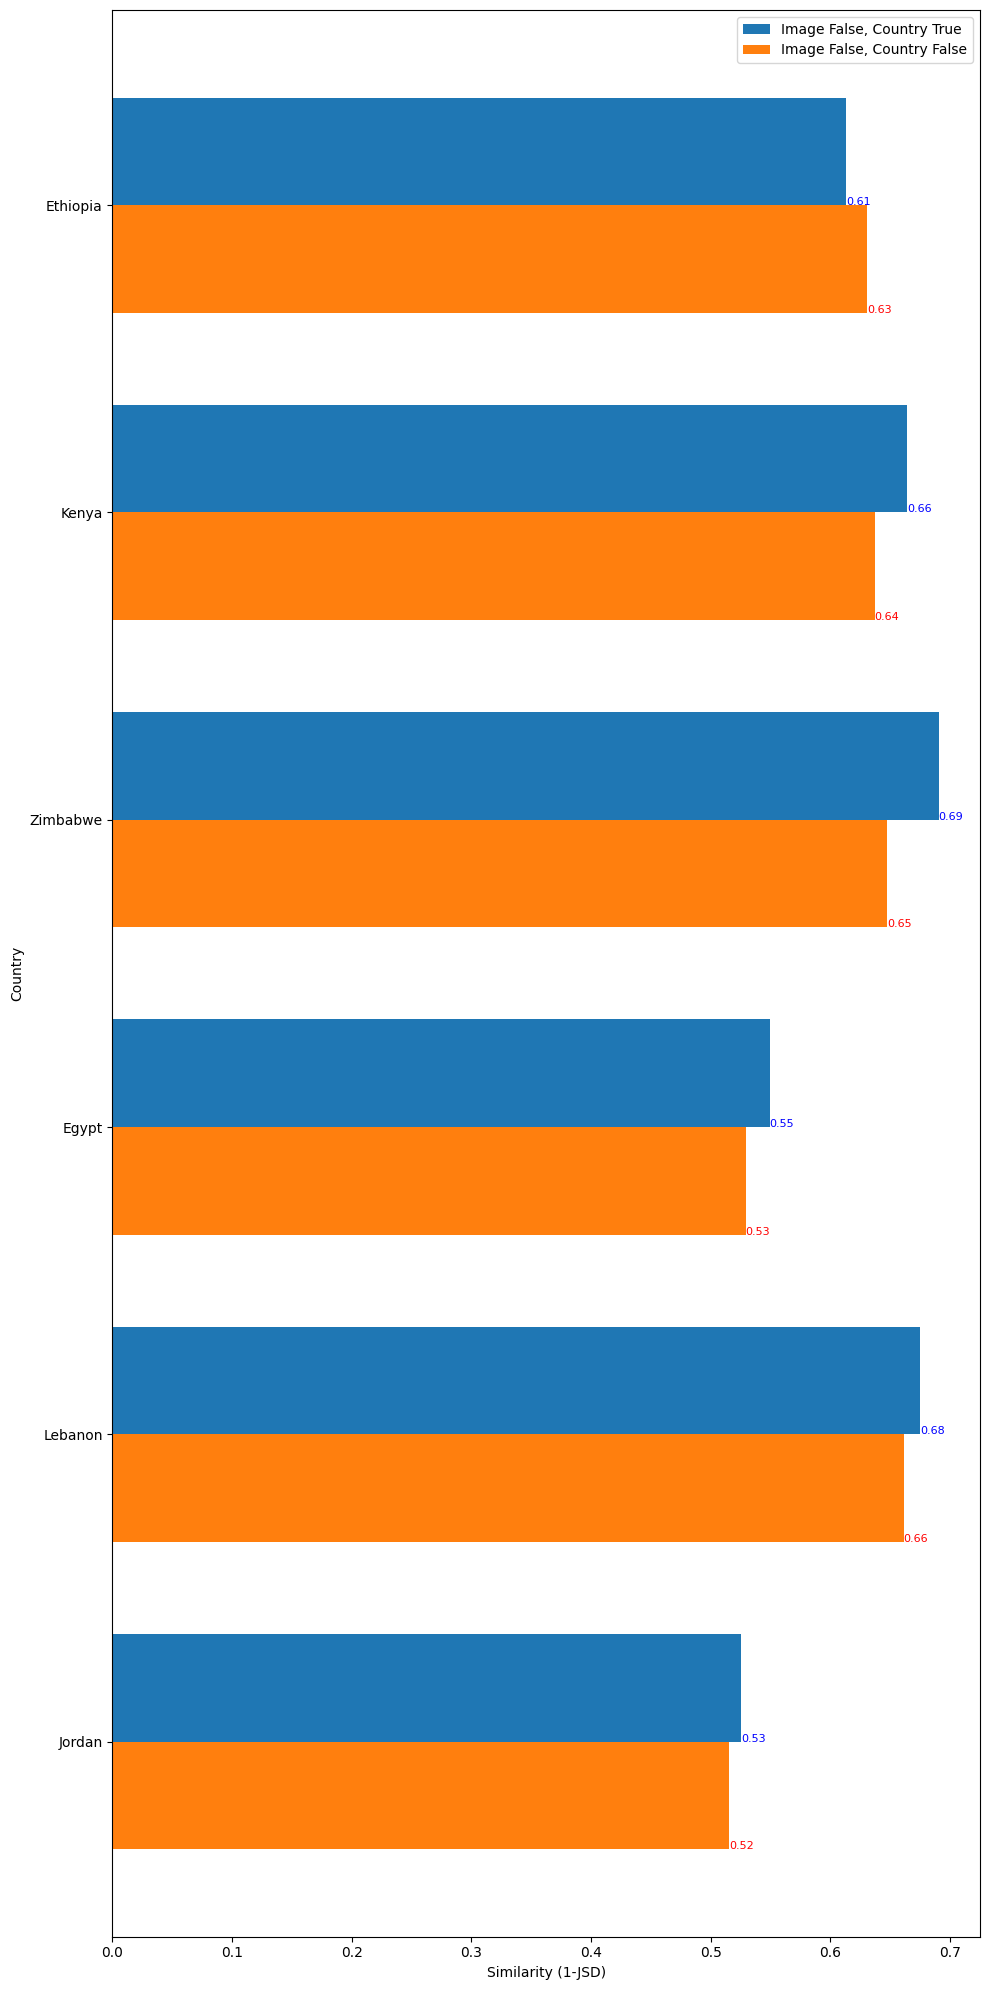

In [80]:
# Plot the jsd values for each country side by side in bar chart
# make country as y-axis and jsd as x-axis

import matplotlib.pyplot as plt

def plot_jsd(jsd_country_df1, jsd_country_df2):
    fig, ax = plt.subplots( figsize=(10, 20))
    # make country as y-axis and jsd as x-axis
    countries = list(jsd_country_df1.keys())
    jsd_values_df1 = list(jsd_country_df1.values())
    jsd_values_df2 = list(jsd_country_df2.values())
    x = np.arange(len(countries))
    width = 0.35

    # add the jsd values at the end of the bar
    for i, v in enumerate(jsd_values_df1):
        ax.text(v, i, str(round(v, 2)), color='blue', fontsize=8)
    # text is not alligned properly. make it a little down
    for i, v in enumerate(jsd_values_df2):
        ax.text(v, i-0.35, str(round(v, 2)), color='red', fontsize=8)

    ax.barh(x + width/2, jsd_values_df1, width, label=setting_1)
    ax.barh(x - width/2, jsd_values_df2, width, label=setting_2)

    ax.set_xlabel('Similarity (1-JSD)')
    ax.set_ylabel('Country')
    ax.set_yticks(x)
    ax.set_yticklabels(countries, fontsize=10)
    ax.legend()
    plt.tight_layout() # to make sure the labels are not cut off
    plt.show()

plot_jsd(jsd_country_df1, jsd_country_df2)

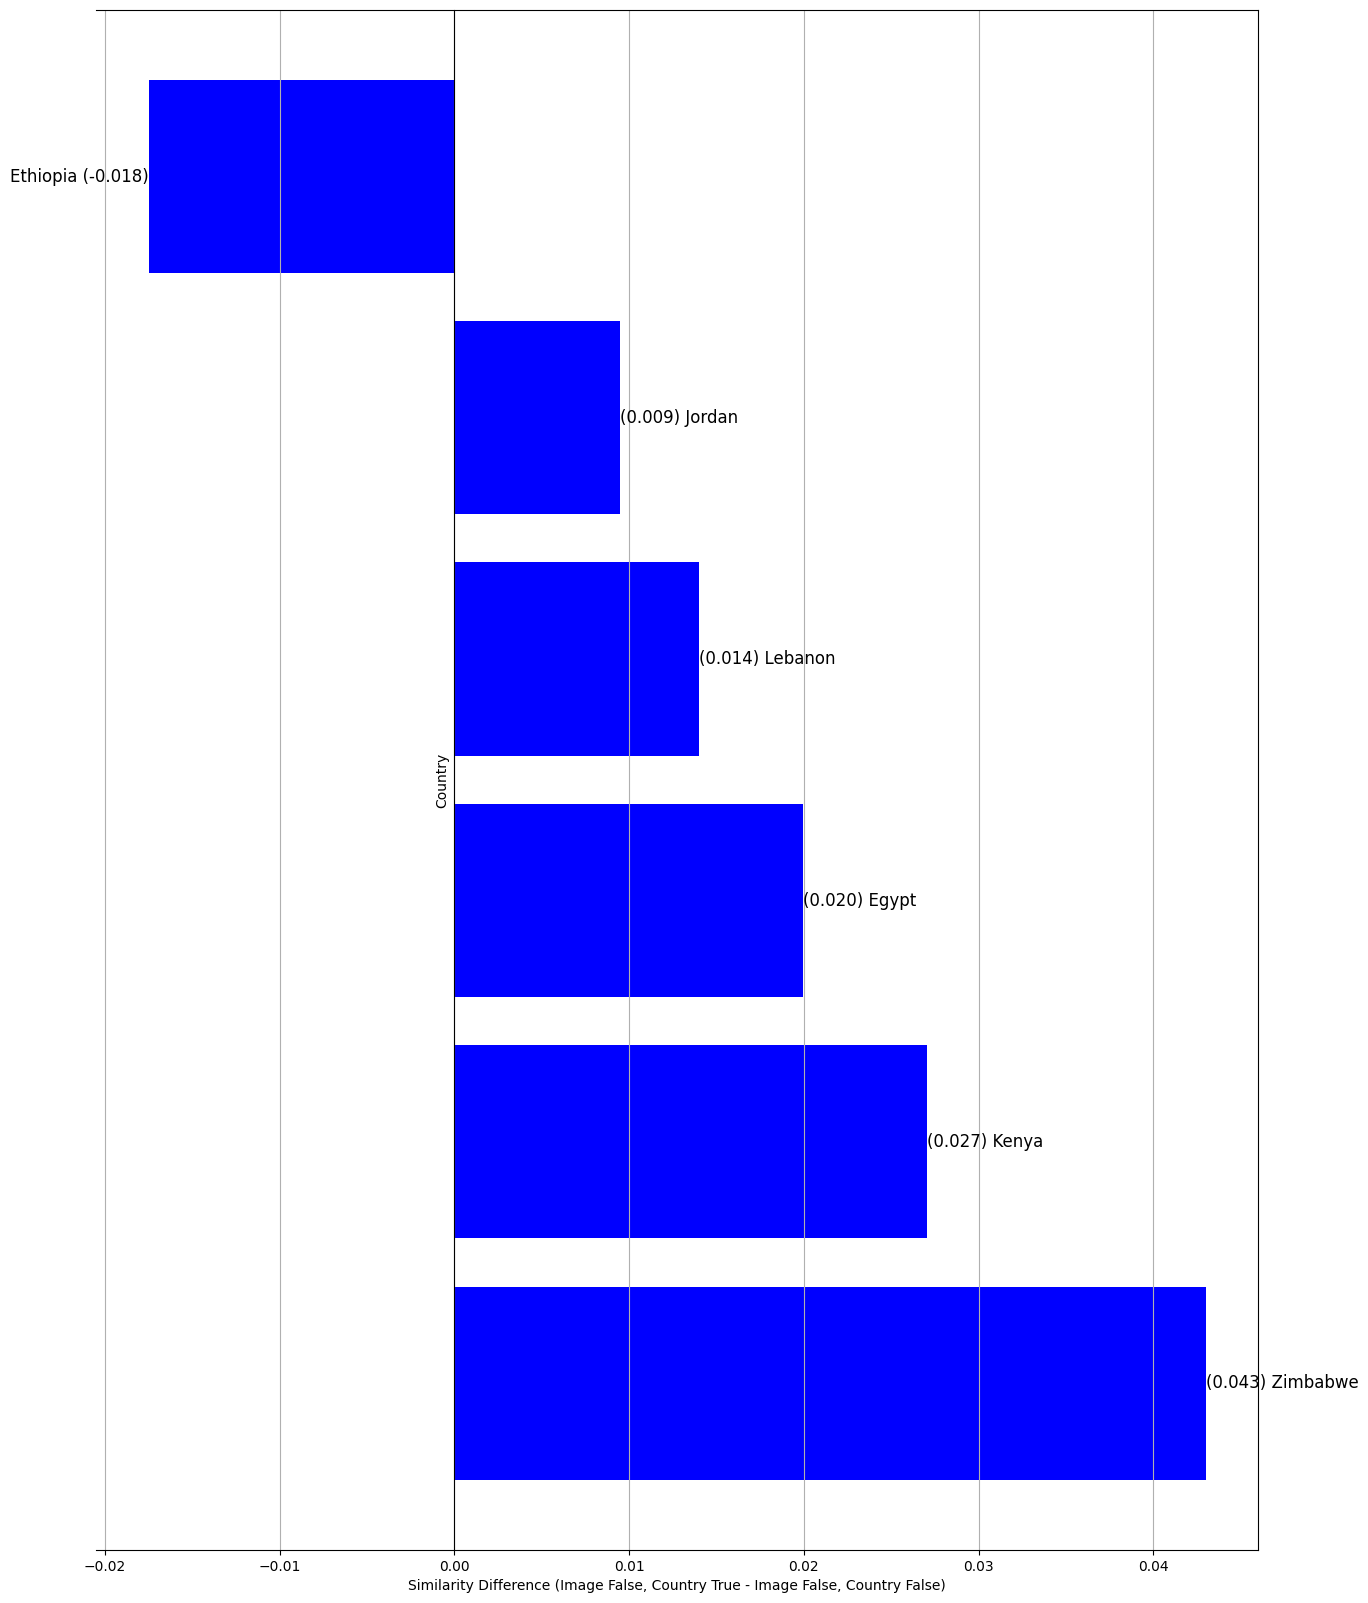

In [81]:

def plot_jsd_difference(jsd_country_df1, jsd_country_df2):
    # Calculate the JSD difference
    jsd_diff = {country: jsd_country_df1[country] - jsd_country_df2[country] for country in jsd_country_df1.keys()}
    jsd_diff = dict(sorted(jsd_diff.items(), key=lambda item: item[1], reverse=True))

    countries = list(jsd_diff.keys())
    jsd_diff_values = list(jsd_diff.values())
    x = np.arange(len(countries))

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 20))
    bars = ax.barh(x, jsd_diff_values, color='blue')
    
    # Set labels
    ax.set_xlabel(f'Similarity Difference ({setting_1} - {setting_2})')
    ax.set_ylabel('Country')

    # Remove the y-ticks and labels (we will add custom labels)
    ax.set_yticks([])
    
    # Move the y-axis to x=0
    ax.spines['left'].set_position(('data', 0))  # Move the left spine to x=0

    # Customize the grid and ticks
    ax.xaxis.grid(True)
    ax.tick_params(axis='y', which='both', left=True, right=False)

    # Add sim values and country names at the end of the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        country_name = countries[i]
        if width < 0:
            # Bar extends to the left
            ax.text(width, bar.get_y() + bar.get_height() / 2, f'{country_name} ({width:.3f})',
                    va='center', ha='right', color='black', fontsize=12)
        else:
            # Bar extends to the right
            ax.text(width, bar.get_y() + bar.get_height() / 2, f'({width:.3f}) {country_name}', 
                    va='center', ha='left', color='black', fontsize=12)

    # Show the plot
    plt.show()

plot_jsd_difference(jsd_country_df1, jsd_country_df2)

In [82]:
a = [0, 0.2, 0.8, 0]
b = [0.1, 0.2, 0.9, 0]
ans = jensenshannon(a, b)
ans

0.17332931375220653

In [83]:
import scipy, copy
import numpy as np
from scipy.spatial.distance import jensenshannon

# for each country, calculate jsd for each question and add the similarity value to the list
def add_jsd_tolist(joint_dict_country_wvs_options):
    for country_dict in tqdm(joint_dict_country_wvs_options):
        country = list(country_dict.keys())[0]
        for ques_vals in country_dict[country]:
            question, dist1, dist2 = ques_vals[0], np.array(ques_vals[1]), np.array(ques_vals[2])
            similarity = 1 - jensenshannon(dist1, dist2)
            breakpoint()
            ques_vals.append(similarity)

    return joint_dict_country_wvs_options

joint_dict_df1 = copy.deepcopy(joint_dict_country_df1)
joint_dict_df2 = copy.deepcopy(joint_dict_country_df2)

jsd_df1 = add_jsd_tolist(joint_dict_df1)
jsd_df2 = add_jsd_tolist(joint_dict_df2)

100%|██████████| 6/6 [00:00<00:00, 28760.94it/s]


In [84]:
# jsd_df1

In [85]:
# remove nan values
jsd_values_df1 = {country: [val[6] for val in jsd_dict[country] if not np.isnan(val[6])] for jsd_dict in jsd_df1 for country, jsd_vals in jsd_dict.items()}
jsd_values_df2 = {country: [val[6] for val in jsd_dict[country] if not np.isnan(val[6])] for jsd_dict in jsd_df2 for country, jsd_vals in jsd_dict.items()}

# # calculate the mean of jsd values per country
jsd_min_max_mean_df1 = {country: [np.min(val), np.max(val), np.mean(val)] for country, val in jsd_values_df1.items()}
jsd_min_max_mean_df2 = {country: [np.min(val), np.max(val), np.mean(val)] for country, val in jsd_values_df2.items()}

print(jsd_min_max_mean_df1)
print(jsd_min_max_mean_df2)

{'Jordan': [0.5250636657582002, 0.5250636657582002, 0.5250636657582002], 'Lebanon': [0.6750738243091094, 0.6750738243091094, 0.6750738243091094], 'Egypt': [0.5491313073290819, 0.5491313073290819, 0.5491313073290819], 'Zimbabwe': [0.6904137531502657, 0.6904137531502657, 0.6904137531502657], 'Kenya': [0.6639405392685307, 0.6639405392685307, 0.6639405392685307], 'Ethiopia': [0.6128580058630002, 0.6128580058630002, 0.6128580058630002]}
{'Jordan': [0.5155776118810975, 0.5155776118810975, 0.5155776118810975], 'Lebanon': [0.661060404027983, 0.661060404027983, 0.661060404027983], 'Egypt': [0.5292005957455334, 0.5292005957455334, 0.5292005957455334], 'Zimbabwe': [0.6474171613291728, 0.6474171613291728, 0.6474171613291728], 'Kenya': [0.6368760725342535, 0.6368760725342535, 0.6368760725342535], 'Ethiopia': [0.6303582099304523, 0.6303582099304523, 0.6303582099304523]}


In [86]:
# split jsd_selected_df1 such that one has questions etc with similarity  <= 0.5 and other has > 0.5
# do this for all countries
low_threshold = 0.3
high_threshold = 0.8

def split_jsd(values):
    jsd_low_split = {}
    jsd_high_split = {}
    for country_dict in tqdm(values):
        country = list(country_dict.keys())[0]
        jsd_low = []; jsd_high = []; 
        for ques_vals in country_dict[country]:
            if ques_vals[6] <= low_threshold:
                breakpoint()
                jsd_low.append(ques_vals.copy())

            elif ques_vals[6] >= high_threshold:
                jsd_high.append(ques_vals.copy())
        
        jsd_low_split[country] = jsd_low
        jsd_high_split[country] = jsd_high
        
    return jsd_low_split, jsd_high_split

jsd_low_split_df1, jsd_high_split_df1 = split_jsd(jsd_df1)
jsd_low_split_df2, jsd_high_split_df2 = split_jsd(jsd_df2)

print(f" JSD values <= {low_threshold}: {jsd_low_split_df1}")

print(f"DF1: sum of values <= {low_threshold}: {sum([len(val) for val in jsd_low_split_df1.values()])}")
print(f"DF1: sum of values >= {high_threshold}: {sum([len(val) for val in jsd_high_split_df1.values()])}")

print(f"DF2: sum of values <= {low_threshold}: {sum([len(val) for val in jsd_low_split_df2.values()])}")
print(f"DF2: sum of values >= {high_threshold}: {sum([len(val) for val in jsd_high_split_df2.values()])}")

100%|██████████| 6/6 [00:00<00:00, 174762.67it/s]

 JSD values <= 0.3: {'Jordan': [], 'Lebanon': [], 'Egypt': [], 'Zimbabwe': [], 'Kenya': [], 'Ethiopia': []}
DF1: sum of values <= 0.3: 0
DF1: sum of values >= 0.8: 0
DF2: sum of values <= 0.3: 0
DF2: sum of values >= 0.8: 0


In [87]:
# jsd_low_split_df1['Iran']

In [88]:
# find the common questions in both low similarity for df1 and df2
# questions for first value of the list of lists

def get_common_questions(df1, df2):
    common_questions = {}
    for country in df1.keys():
        questions_df1 = [val[0] for val in df1[country]]
        questions_df2 = [val[0] for val in df2[country]]
        breakpoint()
        common_questions[country] = set(questions_df1).intersection(set(questions_df2))
    return common_questions

common_questions = get_common_questions(jsd_low_split_df1, jsd_low_split_df2)
common_questions_count = {key: len(value) for key, value in common_questions.items()}
print(common_questions_count)

{'Jordan': 0, 'Lebanon': 0, 'Egypt': 0, 'Zimbabwe': 0, 'Kenya': 0, 'Ethiopia': 0}
